In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [2]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

In [3]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K318', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    # "nâng tay trái_Thinking and Acting": "nâng tay trái",
    # "nâng tay phải_Thinking and Acting": "nâng tay phải",
    # "nâng chân trái_Thinking and Acting": "nâng chân trái",
    # "nâng chân phải_Thinking and Acting": "nâng chân phải",
    # "gật đầu_Thinking and Acting": "gật đầu",
    # "lắc đầu_Thinking and Acting": "lắc đầu",
    # "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


subject:  10%|█         | 11/109 [00:00<00:01, 92.72it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  24%|██▍       | 26/109 [00:00<00:03, 26.30it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  28%|██▊       | 30/109 [00:01<00:02, 27.67it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) 

loaded 97 subjects - 24972 epochs
CPU times: user 1min 15s, sys: 7.77 s, total: 1min 22s
Wall time: 1min 23s


,subject,scenario,event,label,trial,split,epochs
0,K001,nâng tay trái,Thinking,nâng tay trái,0,train,9
1,K001,nâng tay trái,Resting,rest,0,train,10
2,K001,nâng tay trái,Resting,rest,1,train,5
3,K001,nâng tay trái,Thinking,nâng tay trái,1,train,10
4,K001,nâng tay trái,Resting,rest,2,train,4
...,...,...,...,...,...,...,...
2749,K375,nâng chân phải,Resting,rest,2,train,4
2750,K375,nâng chân phải,Resting,rest,3,train,5
2751,K375,nâng chân phải,Thinking,nâng chân phải,2,train,11
2752,K375,nâng chân phải,Resting,rest,4,train,6


In [4]:
ds.datasets[0].windows.event_id

{'rest': 0,
 'nâng chân phải': 1,
 'nâng chân trái': 2,
 'nâng tay phải': 3,
 'nâng tay trái': 4}

In [5]:
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict

In [6]:
ds_ea = deepcopy(ds)
euclidean_alignment(ds_ea, target_subject=None, labeled_trials=None)

subject: 100%|██████████| 97/97 [00:08<00:00, 11.24it/s]


In [18]:
train_trials = {
    "rest": [0, 1],
    "nâng chân trái": [0],
    "nâng chân phải": [0],
    "nâng tay trái": [0],
    "nâng tay phải": [0],
}

# valid_trials = {
#     "rest": [2, 3],
#     "nâng chân trái": [1],
#     "nâng chân phải": [1],
#     "nâng tay trái": [1],
#     "nâng tay phải": [1],
# }

# test_trials = {
#     "rest": [4, 5],
#     "nâng chân trái": [2],
#     "nâng chân phải": [2],
#     "nâng tay trái": [2],
#     "nâng tay phải": [2],
# }

test_subjects = {
    'K300', 'K309', 'K310', 'K311', 'K312', 
    'K313', 'K314', 'K315', 'K316', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
}

test_subjects = sorted(list(test_subjects))
# test_subjects = ["K309"]

test_acc = list()
test_f1 = list()
for subject in tqdm(test_subjects, desc="subject"):
    # if subject != "K309":
    #     continue
    
    print(f"==========subject {subject}==========")
    
    # init data
#     # intra-subject
#     Xtrain = list()
#     Ytrain = list()
#     Xtest = list()
#     Ytest = list()
#     for i, r in ds_info[ds_info["subject"] == subject].iterrows():
#         x = ds.datasets[i].windows.get_data()
#         y = ds.datasets[i].y
#         if r["trial"] in train_trials[r["label"]]:
#             Xtrain.append(x)
#             Ytrain.extend(y)
#         else:
#             Xtest.append(x)
#             Ytest.extend(y)
            
#     Xtrain = np.concatenate(Xtrain, axis=0)
#     Ytrain = np.array(Ytrain, dtype=int)
#     Xtest = np.concatenate(Xtest, axis=0)
#     Ytest = np.array(Ytest, dtype=int)
    
    # EA
    Xtrain = list()
    Ytrain = list()
    Xtest = list()
    Ytest = list()
    for subj in ds_info["subject"].unique():
        if subj == "K318":
            continue
        if subj not in test_subjects:
            continue
            
        Xsub = list()
        Ysub = list()
        for i, r in ds_info[ds_info["subject"] == subj].iterrows():
            # x = ds.datasets[i].windows.get_data()
            # y = ds.datasets[i].y
            x = ds_ea.datasets[i].windows.get_data()
            y = ds_ea.datasets[i].y
            Xsub.append(x)
            Ysub.extend(y)
        
        Xsub = np.concatenate(Xsub, axis=0)
        Ysub = np.array(Ysub, dtype=int)
        
        if subj != subject:
            Xtrain.append(Xsub)
            Ytrain.append(Ysub)
        else:
            Xtest.append(Xsub)
            Ytest.append(Ysub)
            
    Xtrain = np.concatenate(Xtrain, axis=0)
    Ytrain = np.concatenate(Ytrain, axis=0)
    Xtest = np.concatenate(Xtest, axis=0)
    Ytest = np.concatenate(Ytest, axis=0)
    
    # LA
#     DXtrain = defaultdict(list)
#     DYtrain = defaultdict(list)
#     DXtest = defaultdict(list)
#     DYtest = defaultdict(list)
#     for subj in ds_info["subject"].unique():
#         if subj == "K318":
#             continue
            
#         for i, r in ds_info[ds_info["subject"] == subj].iterrows():
#             x = ds.datasets[i].windows.get_data()
#             y = ds.datasets[i].y
#             if subj == subject:
#                 if r["trial"] in train_trials[r["label"]]:
#                     DXtrain[subj].append(x)
#                     DYtrain[subj].extend(y)
#                 else:
#                     DXtest[subj].append(x)
#                     DYtest[subj].extend(y)
#             else:
#                 DXtrain[subj].append(x)
#                 DYtrain[subj].extend(y)
                
#     for k, v in DXtrain.items():
#         DXtrain[k] = np.concatenate(v, axis=0)
#     for k, v in DXtest.items():
#         DXtest[k] = np.concatenate(v, axis=0)
#     for k, v in DYtrain.items():
#         DYtrain[k] = np.array(v, dtype=int)
#     for k, v in DYtest.items():
#         DYtest[k] = np.array(v, dtype=int)
    
#     r = np_compute_target_transform_mats(DXtrain[subject], DYtrain[subject])
#     for k, v in DXtrain.items():
#         if k == subject:
#             continue
#         DXtrain[k] = np_label_alignment(v, DYtrain[k], r)
        
#     Xtrain = list()
#     Ytrain = list()
#     for k, v in DXtrain.items():
#         Xtrain.append(v)
#         Ytrain.append(DYtrain[k])
        
#     Xtrain = np.concatenate(Xtrain, axis=0)
#     Ytrain = np.concatenate(Ytrain, axis=0)
#     Xtest = DXtest[subject]
#     Ytest = DYtest[subject]
    
    print(np.bincount(Ytrain), np.bincount(Ytest))
    
    # init model
    # clf = make_pipeline(
    #     Covariances("cov"),
    #     TSclassifier(
    #         metric="riemann",
    #         # clf=SVC(
    #         clf=LinearSVC(
    #             C=1.0,
    #             # kernel="rbf",
    #             tol=1e-7,
    #             max_iter=30000,
    #             class_weight="balanced",
    #             random_state=42,
    #         ),
    #         # clf=LinearDiscriminantAnalysis(
    #         #     solver="lsqr",
    #         #     shrinkage="auto",
    #         #     n_components=None,
    #         #     tol=1e-7,
    #         #     covariance_estimator=None,
    #         # ),
    #     ),
    # )
    
    clf = make_pipeline(
        mne.decoding.CSP(
            n_components=4,
            # reg="ledoit_wolf",
            log=True,
            norm_trace=False,
        ),
        # SVC(
        LinearSVC(
            C=1.0,
            # kernel="rbf",
            tol=1e-7,
            max_iter=30000,
            class_weight="balanced",
            random_state=42,
        ),
        # OneVsRestClassifier(LinearSVC(C=1.0, tol=1e-7, max_iter=30000, class_weight='balanced', random_state=42), n_jobs=-1),
        # LinearDiscriminantAnalysis(
        #     solver="lsqr",
        #     shrinkage="auto",
        #     n_components=None,
        #     tol=1e-7,
        #     covariance_estimator=None,
        # ),
    )
    
    # training
    clf.fit(Xtrain, Ytrain)
    
    # evaluate
    Ypred = clf.predict(Xtest)
    
    acc = metrics.balanced_accuracy_score(Ytest, Ypred)
    f1 = metrics.f1_score(Ytest, Ypred, average='weighted')
    test_acc.append(acc)
    test_f1.append(f1)
    print(f"accuracy: {acc}")
    print(f"f1_weighted: {f1}")
    print(f"confusion matrix:\n{metrics.confusion_matrix(Ytest, Ypred)}")
    
    # break

subject:   0%|          | 0/60 [00:00<?, ?it/s]

==========subject K300==========
[9471 1870 1863 1866 1850] [236  24  30  28  48]


subject:   2%|▏         | 1/60 [00:23<22:54, 23.30s/it]

accuracy: 0.42408797417272004
f1_weighted: 0.6115707454668231
confusion matrix:
[[222   6   3   4   1]
 [  1  21   2   0   0]
 [ 11  12   7   0   0]
 [ 16  10   0   2   0]
 [ 45   2   1   0   0]]
==========subject K309==========
[9491 1864 1866 1864 1869] [216  30  27  30  29]


subject:   3%|▎         | 2/60 [00:47<22:45, 23.55s/it]

accuracy: 0.5396296296296297
f1_weighted: 0.7274706684538076
confusion matrix:
[[186   4   2  12  12]
 [  0  26   4   0   0]
 [  0  15  10   1   1]
 [  2   6   4  18   0]
 [  0   2  19   8   0]]
==========subject K310==========
[9462 1860 1862 1861 1865] [245  34  31  33  33]


subject:   5%|▌         | 3/60 [01:12<23:19, 24.55s/it]

accuracy: 0.40138309869402305
f1_weighted: 0.6490179122428085
confusion matrix:
[[198  16   3  16  12]
 [  0  15   0  17   2]
 [  0   5   0  18   8]
 [  2   3   2  21   5]
 [  6   1   1  21   4]]
==========subject K311==========
[9471 1858 1865 1857 1864] [236  36  28  37  34]


subject:   7%|▋         | 4/60 [01:39<23:40, 25.36s/it]

accuracy: 0.3984981349388129
f1_weighted: 0.6870607559890483
confusion matrix:
[[234   0   2   0   0]
 [  0  27   4   2   3]
 [  0  23   4   0   1]
 [  0  26   6   4   1]
 [ 14  19   1   0   0]]
==========subject K312==========
[9480 1853 1862 1856 1851] [227  41  31  38  47]


subject:   8%|▊         | 5/60 [02:03<22:52, 24.96s/it]

accuracy: 0.40369264486137457
f1_weighted: 0.6519102671188958
confusion matrix:
[[213   5   7   1   1]
 [  3  33   0   5   0]
 [  0  15   1  15   0]
 [  0   3  26   6   3]
 [ 19   5  18   1   4]]
==========subject K313==========
[9488 1856 1856 1850 1862] [219  38  37  44  36]


subject:  10%|█         | 6/60 [02:35<24:26, 27.16s/it]

accuracy: 0.4600736608667394
f1_weighted: 0.6464275350952675
confusion matrix:
[[213   0   4   1   1]
 [  0  37   1   0   0]
 [  2  29   6   0   0]
 [  9  16  11   6   2]
 [ 28   5   0   1   2]]
==========subject K314==========
[9491 1865 1864 1865 1864] [216  29  29  29  34]


subject:  12%|█▏        | 7/60 [02:57<22:37, 25.62s/it]

accuracy: 0.43707647810081884
f1_weighted: 0.7015616770987799
confusion matrix:
[[205   4   3   4   0]
 [  0  20   4   5   0]
 [  0  16   7   6   0]
 [  2  11   8   8   0]
 [  4  18   4   7   1]]
==========subject K315==========
[9460 1857 1857 1860 1863] [247  37  36  34  35]


subject:  13%|█▎        | 8/60 [03:26<23:11, 26.77s/it]

accuracy: 0.3945945945945946
f1_weighted: 0.6434287151964042
confusion matrix:
[[247   0   0   0   0]
 [  1  36   0   0   0]
 [  2  34   0   0   0]
 [  6  27   1   0   0]
 [ 24   8   3   0   0]]
==========subject K316==========
[9452 1857 1862 1861 1865] [255  37  31  33  33]


subject:  15%|█▌        | 9/60 [03:51<22:14, 26.16s/it]

accuracy: 0.3773396926338103
f1_weighted: 0.6413923096552245
confusion matrix:
[[233  13   0   6   3]
 [  1  36   0   0   0]
 [  0  31   0   0   0]
 [  2  28   3   0   0]
 [ 21   8   4   0   0]]
==========subject K319==========
[9446 1866 1868 1863 1876] [261  28  25  31  22]


subject:  17%|█▋        | 10/60 [04:19<22:10, 26.61s/it]

accuracy: 0.4014354573865141
f1_weighted: 0.7087468275502209
confusion matrix:
[[231  22   6   1   1]
 [  0  26   2   0   0]
 [  0  21   0   4   0]
 [  4  16   3   6   2]
 [  5   7   1   9   0]]
==========subject K320==========
[9516 1865 1868 1867 1873] [191  29  25  27  25]


subject:  18%|█▊        | 11/60 [04:45<21:42, 26.59s/it]

accuracy: 0.3605027782792723
f1_weighted: 0.635267600898914
confusion matrix:
[[175  11   3   2   0]
 [  2  19   1   6   1]
 [  2  18   3   1   1]
 [ 14  10   0   3   0]
 [ 12  13   0   0   0]]
==========subject K321==========
[9634 1865 1862 1866 1870] [73 29 31 28 28]


subject:  20%|██        | 12/60 [05:10<20:43, 25.91s/it]

accuracy: 0.3704830764341332
f1_weighted: 0.4489370037142694
confusion matrix:
[[73  0  0  0  0]
 [ 2 16  4  7  0]
 [ 8 16  6  1  0]
 [ 6 19  1  1  1]
 [13  7  3  3  2]]
==========subject K322==========
[9570 1867 1866 1867 1871] [137  27  27  27  27]


subject:  22%|██▏       | 13/60 [05:43<22:07, 28.25s/it]

accuracy: 0.4905650175723168
f1_weighted: 0.6779189875488024
confusion matrix:
[[128   8   1   0   0]
 [  0  25   2   0   0]
 [  2   9   8   1   7]
 [  2   7   2   8   8]
 [  0  26   0   1   0]]
==========subject K323==========
[9588 1869 1867 1869 1871] [119  25  26  25  27]


subject:  23%|██▎       | 14/60 [06:06<20:16, 26.45s/it]

accuracy: 0.4288274078862314
f1_weighted: 0.6024509803921568
confusion matrix:
[[114   3   1   1   0]
 [  1  21   2   1   0]
 [  1  15   9   1   0]
 [  2  21   2   0   0]
 [  3  17   5   2   0]]
==========subject K324==========
[9623 1867 1865 1862 1867] [84 27 28 32 31]


subject:  25%|██▌       | 15/60 [06:36<20:43, 27.63s/it]

accuracy: 0.4059555811571941
f1_weighted: 0.505089942749309
confusion matrix:
[[81  1  2  0  0]
 [ 2 15  6  4  0]
 [ 3 13  2 10  0]
 [ 8  3  7 13  1]
 [ 8  2  7 13  1]]
==========subject K325==========
[9619 1865 1851 1867 1872] [88 29 42 27 26]


subject:  27%|██▋       | 16/60 [07:01<19:47, 26.99s/it]

accuracy: 0.47374707029879454
f1_weighted: 0.571958682127004
confusion matrix:
[[88  0  0  0  0]
 [ 0 20  2  6  1]
 [ 6 22  8  6  0]
 [ 2 13  2  8  2]
 [ 9  6  2  4  5]]
==========subject K326==========
[9614 1860 1857 1859 1864] [93 34 36 35 34]


subject:  28%|██▊       | 17/60 [07:25<18:43, 26.12s/it]

accuracy: 0.2537007921448149
f1_weighted: 0.3396122361497484
confusion matrix:
[[91  2  0  0  0]
 [19  6  3  4  2]
 [16 18  2  0  0]
 [25  8  1  1  0]
 [ 7 19  2  5  1]]
==========subject K327==========
[9626 1852 1859 1865 1867] [81 42 34 29 31]


subject:  30%|███       | 18/60 [07:56<19:09, 27.38s/it]

accuracy: 0.36097624811882484
f1_weighted: 0.4519109641605837
confusion matrix:
[[81  0  0  0  0]
 [ 6 21  6  8  1]
 [ 6 17  7  4  0]
 [ 8 11  7  1  2]
 [11 13  3  2  2]]
==========subject K328==========
[9496 1867 1859 1862 1862] [211  27  34  32  36]


subject:  32%|███▏      | 19/60 [08:19<17:50, 26.10s/it]

accuracy: 0.316075088539892
f1_weighted: 0.6305190490518967
confusion matrix:
[[207   0   1   0   3]
 [  8   7   3   9   0]
 [  5  19   2   8   0]
 [  3  19   1   9   0]
 [  5  14   0  17   0]]
==========subject K329==========
[9591 1865 1867 1866 1869] [116  29  26  28  29]


subject:  33%|███▎      | 20/60 [08:50<18:25, 27.65s/it]

accuracy: 0.39655172413793105
f1_weighted: 0.5439422676264781
confusion matrix:
[[112   1   1   2   0]
 [  4  15   0  10   0]
 [  6   7   0  10   3]
 [  8   6   0  14   0]
 [ 18   0   1  10   0]]
==========subject K330==========
[9629 1867 1865 1869 1871] [78 27 28 25 27]


subject:  35%|███▌      | 21/60 [09:14<17:17, 26.61s/it]

accuracy: 0.41409198209198206
f1_weighted: 0.5426286362479972
confusion matrix:
[[77  0  1  0  0]
 [ 1 16  1  9  0]
 [ 1 17  2  8  0]
 [ 7 13  0  4  1]
 [ 3  9  3  5  7]]
==========subject K331==========
[9616 1866 1865 1867 1867] [91 28 28 27 31]


subject:  37%|███▋      | 22/60 [09:41<16:51, 26.61s/it]

accuracy: 0.3257020757020757
f1_weighted: 0.4328715416640444
confusion matrix:
[[85  4  1  1  0]
 [20  7  1  0  0]
 [12 11  0  2  3]
 [ 6  4  0 12  5]
 [11  4  9  7  0]]
==========subject K332==========
[9543 1866 1860 1868 1872] [164  28  33  26  26]


subject:  38%|███▊      | 23/60 [10:09<16:45, 27.18s/it]

accuracy: 0.3835128286347798
f1_weighted: 0.6357678783202497
confusion matrix:
[[159   2   1   1   1]
 [  0  24   4   0   0]
 [  0  30   3   0   0]
 [  0  26   0   0   0]
 [  0  14  11   1   0]]
==========subject K333==========
[9618 1865 1866 1868 1871] [89 29 27 26 27]


subject:  40%|████      | 24/60 [10:34<15:48, 26.35s/it]

accuracy: 0.4637488947833776
f1_weighted: 0.5861012780761546
confusion matrix:
[[89  0  0  0  0]
 [ 2 23  2  2  0]
 [ 1 16  8  0  2]
 [ 3  9  6  5  3]
 [ 7 13  5  1  1]]
==========subject K334==========
[9645 1854 1858 1858 1860] [62 40 35 36 38]


subject:  42%|████▏     | 25/60 [11:07<16:32, 28.36s/it]

accuracy: 0.2888909100708762
f1_weighted: 0.2817580964169744
confusion matrix:
[[60  2  0  0  0]
 [13  9  6  8  4]
 [14 14  4  3  0]
 [18 12  2  4  0]
 [33  1  2  1  1]]
==========subject K335==========
[9648 1858 1859 1863 1859] [59 36 34 31 39]


subject:  43%|████▎     | 26/60 [11:32<15:29, 27.33s/it]

accuracy: 0.364989701422339
f1_weighted: 0.3766415148474492
confusion matrix:
[[59  0  0  0  0]
 [ 2 16 14  4  0]
 [ 0 22  9  1  2]
 [ 7 17  5  2  0]
 [19  7  6  5  2]]
==========subject K336==========
[9634 1856 1857 1857 1864] [73 38 36 37 34]


subject:  45%|████▌     | 27/60 [11:58<14:51, 27.02s/it]

accuracy: 0.5059850872544371
f1_weighted: 0.5342997328975059
confusion matrix:
[[73  0  0  0  0]
 [ 0 32  2  2  2]
 [ 6 10 13  4  3]
 [ 6 12  5 11  3]
 [18  5  2  8  1]]
==========subject K337==========
[9593 1860 1858 1857 1862] [114  34  35  37  36]


subject:  47%|████▋     | 28/60 [12:24<14:11, 26.61s/it]

accuracy: 0.42168493570970356
f1_weighted: 0.5725045091966002
confusion matrix:
[[113   0   0   0   1]
 [  2  21   6   5   0]
 [  1  10   7  11   6]
 [  2  17  10   8   0]
 [  0  10  15   8   3]]
==========subject K338==========
[9334 1859 1842 1858 1866] [373  35  51  36  32]


subject:  48%|████▊     | 29/60 [12:48<13:22, 25.88s/it]

accuracy: 0.3880186578652909
f1_weighted: 0.7066899905854427
confusion matrix:
[[352   9   9   1   2]
 [  0  32   3   0   0]
 [ 14  35   1   1   0]
 [  0  31   5   0   0]
 [  5  12   5   8   2]]
==========subject K339==========
[9418 1861 1862 1857 1864] [289  33  31  37  34]


subject:  50%|█████     | 30/60 [13:21<14:00, 28.02s/it]

accuracy: 0.3931695569378347
f1_weighted: 0.7083298731065639
confusion matrix:
[[278   4   3   3   1]
 [  0  31   2   0   0]
 [  0  29   2   0   0]
 [  0  30   7   0   0]
 [  1   5  19   9   0]]
==========subject K340==========
[9451 1855 1858 1860 1862] [256  39  35  34  36]


subject:  52%|█████▏    | 31/60 [13:46<13:06, 27.12s/it]

accuracy: 0.2935851648351648
f1_weighted: 0.5815104400252058
confusion matrix:
[[216  29   3   7   1]
 [ 13  21   5   0   0]
 [  4  24   3   4   0]
 [ 10  19   4   0   1]
 [  9  14   7   6   0]]
==========subject K342==========
[9426 1868 1869 1868 1874] [281  26  24  26  24]


subject:  53%|█████▎    | 32/60 [14:15<12:52, 27.58s/it]

accuracy: 0.34316999726252395
f1_weighted: 0.7202530707936227
confusion matrix:
[[266  12   3   0   0]
 [  4  20   2   0   0]
 [  1  23   0   0   0]
 [  2  22   2   0   0]
 [  9  14   1   0   0]]
==========subject K343==========
[9453 1871 1869 1869 1874] [254  23  24  25  24]


subject:  55%|█████▌    | 33/60 [14:43<12:34, 27.95s/it]

accuracy: 0.4103674540682415
f1_weighted: 0.7492364976958525
confusion matrix:
[[246   6   0   0   2]
 [  0  23   0   0   0]
 [  0  20   2   0   2]
 [  0  25   0   0   0]
 [  0  18   5   1   0]]
==========subject K344==========
[9446 1869 1866 1865 1875] [261  25  27  29  23]


subject:  57%|█████▋    | 34/60 [15:06<11:27, 26.45s/it]

accuracy: 0.3835095785440613
f1_weighted: 0.68783824840216
confusion matrix:
[[218  37   2   3   1]
 [  0  17   6   1   1]
 [  5   7   9   2   4]
 [  4  16   3   2   4]
 [  4  11   5   3   0]]
==========subject K350==========
[9614 1856 1863 1856 1866] [93 38 30 38 32]


subject:  58%|█████▊    | 35/60 [15:38<11:41, 28.07s/it]

accuracy: 0.4960059422750425
f1_weighted: 0.5790322361481484
confusion matrix:
[[91  0  0  2  0]
 [ 0 31  5  0  2]
 [ 0 17 11  1  1]
 [15 15  1  5  2]
 [ 2 10  7  7  6]]
==========subject K351==========
[9650 1860 1856 1862 1863] [57 34 37 32 35]


subject:  60%|██████    | 36/60 [16:02<10:43, 26.83s/it]

accuracy: 0.401871451283216
f1_weighted: 0.39384615384615385
confusion matrix:
[[57  0  0  0  0]
 [ 5 24  2  3  0]
 [ 8 21  7  1  0]
 [10  9 10  0  3]
 [15  2  0 14  4]]
==========subject K352==========
[9659 1853 1857 1857 1854] [48 41 36 37 44]


subject:  62%|██████▏   | 37/60 [16:31<10:28, 27.32s/it]

accuracy: 0.3353219072731268
f1_weighted: 0.2709414621724946
confusion matrix:
[[48  0  0  0  0]
 [ 5 21 13  2  0]
 [11 17  3  2  3]
 [14  9  8  3  3]
 [30  7  5  2  0]]
==========subject K353==========
[9655 1862 1858 1857 1869] [52 32 35 37 29]


subject:  63%|██████▎   | 38/60 [16:54<09:35, 26.14s/it]

accuracy: 0.32285714285714284
f1_weighted: 0.27190638914776843
confusion matrix:
[[52  0  0  0  0]
 [ 2 16 14  0  0]
 [13 18  4  0  0]
 [26  6  3  0  2]
 [29  0  0  0  0]]
==========subject K354==========
[9647 1867 1865 1862 1866] [60 27 28 32 32]


subject:  65%|██████▌   | 39/60 [17:20<09:05, 25.97s/it]

accuracy: 0.5000992063492063
f1_weighted: 0.4780483596126055
confusion matrix:
[[60  0  0  0  0]
 [ 1 24  2  0  0]
 [ 0 16 11  1  0]
 [16  6  3  7  0]
 [31  1  0  0  0]]
==========subject K355==========
[9464 1866 1864 1863 1871] [243  28  29  31  27]


subject:  67%|██████▋   | 40/60 [17:51<09:14, 27.70s/it]

accuracy: 0.43807123860269337
f1_weighted: 0.6967596156538746
confusion matrix:
[[203  27   4   9   0]
 [  0  18   8   2   0]
 [  2  16   7   1   3]
 [  1  12   7  10   1]
 [  7   3   9   4   4]]
==========subject K356==========
[9643 1865 1865 1864 1869] [64 29 28 30 29]


subject:  68%|██████▊   | 41/60 [18:14<08:18, 26.22s/it]

accuracy: 0.3381937602627258
f1_weighted: 0.3776324173636002
confusion matrix:
[[64  0  0  0  0]
 [ 6 17  3  3  0]
 [ 3 14  2  6  3]
 [ 6 17  5  1  1]
 [12 13  4  0  0]]
==========subject K357==========
[9520 1865 1863 1866 1871] [187  29  30  28  27]


subject:  70%|███████   | 42/60 [18:43<08:04, 26.89s/it]

accuracy: 0.3115083023805133
f1_weighted: 0.5957896229416303
confusion matrix:
[[156  21   3   2   5]
 [  3  12   5   5   4]
 [  0  16   5   9   0]
 [  7   7   8   4   2]
 [  6  11   7   3   0]]
==========subject K358==========
[9507 1868 1864 1867 1868] [200  26  29  27  30]


subject:  72%|███████▏  | 43/60 [19:08<07:30, 26.49s/it]

accuracy: 0.4536754101581688
f1_weighted: 0.7047596589418129
confusion matrix:
[[198   0   0   1   1]
 [  1  24   1   0   0]
 [  5  17   3   4   0]
 [  4  10   0   5   8]
 [  4  12   4   8   2]]
==========subject K359==========
[9505 1867 1866 1864 1871] [202  27  27  30  27]


subject:  73%|███████▎  | 44/60 [19:34<07:01, 26.35s/it]

accuracy: 0.4175210854418775
f1_weighted: 0.6855904805129379
confusion matrix:
[[198   1   0   1   2]
 [  0  26   0   1   0]
 [  1  23   2   1   0]
 [  1  25   2   1   1]
 [  6  16   3   1   1]]
==========subject K360==========
[9508 1861 1854 1857 1864] [199  33  39  37  34]


subject:  75%|███████▌  | 45/60 [20:04<06:50, 27.36s/it]

accuracy: 0.5481526204553103
f1_weighted: 0.7036936802454001
confusion matrix:
[[182   8   6   3   0]
 [  1  31   1   0   0]
 [  3  15  14   7   0]
 [  6  10   5  13   3]
 [  7   2   8  11   6]]
==========subject K361==========
[9527 1860 1857 1861 1866] [180  34  36  33  32]


subject:  77%|███████▋  | 46/60 [20:27<06:03, 25.97s/it]

accuracy: 0.4613755199049317
f1_weighted: 0.6745326854268063
confusion matrix:
[[171   5   1   1   2]
 [  1   9  20   4   0]
 [  3  13  13   3   4]
 [  5   7   0  20   1]
 [  8   6   0  14   4]]
==========subject K362==========
[9509 1861 1855 1859 1864] [198  33  38  35  34]


subject:  78%|███████▊  | 47/60 [20:56<05:49, 26.87s/it]

accuracy: 0.3281577383744566
f1_weighted: 0.6032150423686568
confusion matrix:
[[191   7   0   0   0]
 [  0  17  16   0   0]
 [  4  28   5   1   0]
 [  8  17   9   0   1]
 [  3  19   1  10   1]]
==========subject K363==========
[9654 1869 1865 1864 1869] [53 25 28 30 29]


subject:  80%|████████  | 48/60 [21:20<05:12, 26.08s/it]

accuracy: 0.30362214580041524
f1_weighted: 0.3684660137052715
confusion matrix:
[[52  0  0  1  0]
 [ 3  2  8 12  0]
 [ 1  9  8 10  0]
 [ 7 16  6  1  0]
 [15  9  0  1  4]]
==========subject K364==========
[9505 1860 1854 1858 1862] [202  34  39  36  36]


subject:  82%|████████▏ | 49/60 [21:46<04:48, 26.20s/it]

accuracy: 0.3585024565804996
f1_weighted: 0.6149611291478837
confusion matrix:
[[200   0   1   1   0]
 [  8  19   3   4   0]
 [  0  33   3   2   1]
 [  4  21   1   5   5]
 [ 12  16   1   6   1]]
==========subject K365==========
[9660 1869 1868 1868 1873] [47 25 25 26 25]


subject:  83%|████████▎ | 50/60 [22:17<04:36, 27.61s/it]

accuracy: 0.37507692307692314
f1_weighted: 0.36758757979634027
confusion matrix:
[[47  0  0  0  0]
 [ 1 17  7  0  0]
 [ 8 16  1  0  0]
 [ 8  9  3  3  3]
 [19  3  1  1  1]]
==========subject K366==========
[9502 1857 1862 1863 1860] [205  37  31  31  38]


subject:  85%|████████▌ | 51/60 [22:41<03:57, 26.39s/it]

accuracy: 0.42032939643855205
f1_weighted: 0.6574457421680481
confusion matrix:
[[204   1   0   0   0]
 [  0  34   2   1   0]
 [  0  26   5   0   0]
 [  2  22   7   0   0]
 [ 11  10  13   3   1]]
==========subject K367==========
[9663 1869 1870 1870 1869] [44 25 23 24 29]


subject:  87%|████████▋ | 52/60 [23:07<03:31, 26.38s/it]

accuracy: 0.41915142428785607
f1_weighted: 0.45445203445203447
confusion matrix:
[[44  0  0  0  0]
 [ 1  9  1 14  0]
 [ 2  4  8  6  3]
 [ 4 13  0  6  1]
 [10  1 10  4  4]]
==========subject K368==========
[9530 1860 1854 1858 1861] [177  34  39  36  37]


subject:  88%|████████▊ | 53/60 [23:35<03:08, 26.89s/it]

accuracy: 0.4607658889812429
f1_weighted: 0.651432157500269
confusion matrix:
[[176   1   0   0   0]
 [  1  27   6   0   0]
 [  1  34   3   0   1]
 [ 12   9   3   8   4]
 [  3   6   1  19   8]]
==========subject K369==========
[9534 1863 1863 1862 1868] [173  31  30  32  30]


subject:  90%|█████████ | 54/60 [23:59<02:36, 26.08s/it]

accuracy: 0.3575531418981913
f1_weighted: 0.6414856870690155
confusion matrix:
[[169   2   0   2   0]
 [  0  17  10   4   0]
 [  0  22   5   3   0]
 [  1  25   4   2   0]
 [  0  14   5  10   1]]
==========subject K370==========
[9510 1858 1860 1863 1869] [197  36  33  31  29]


subject:  92%|█████████▏| 55/60 [24:27<02:13, 26.62s/it]

accuracy: 0.41886270085255983
f1_weighted: 0.6399597245286357
confusion matrix:
[[189   2   0   1   5]
 [  1  33   1   1   0]
 [  3  25   5   0   0]
 [ 12   5  10   1   3]
 [ 19   8   1   0   1]]
==========subject K371==========
[9534 1859 1861 1858 1867] [173  35  32  36  31]


subject:  93%|█████████▎| 56/60 [24:50<01:41, 25.47s/it]

accuracy: 0.4063110147719974
f1_weighted: 0.6248292728663035
confusion matrix:
[[162   6   0   4   1]
 [  0  28   7   0   0]
 [  0  27   5   0   0]
 [  2  19  10   5   0]
 [  5  17   9   0   0]]
==========subject K372==========
[9541 1864 1862 1861 1868] [166  30  31  33  30]


subject:  95%|█████████▌| 57/60 [25:18<01:18, 26.17s/it]

accuracy: 0.38666666666666666
f1_weighted: 0.5925774596784443
confusion matrix:
[[166   0   0   0   0]
 [  2  28   0   0   0]
 [  2  28   0   0   1]
 [  4  21   8   0   0]
 [  7  22   0   1   0]]
==========subject K373==========
[9536 1861 1860 1866 1868] [171  33  33  28  30]


subject:  97%|█████████▋| 58/60 [25:43<00:51, 25.87s/it]

accuracy: 0.40181818181818185
f1_weighted: 0.6428256562011394
confusion matrix:
[[171   0   0   0   0]
 [  4  27   2   0   0]
 [  1  28   3   1   0]
 [  0  21   5   0   2]
 [  6  13   4   4   3]]
==========subject K374==========
[9529 1861 1861 1860 1868] [178  33  32  34  30]


subject:  98%|█████████▊| 59/60 [26:07<00:25, 25.43s/it]

accuracy: 0.38159098419756055
f1_weighted: 0.6115945251313272
confusion matrix:
[[167   6   0   5   0]
 [  0  30   3   0   0]
 [  0  30   1   1   0]
 [  0  12  21   1   0]
 [  4  24   2   0   0]]
==========subject K375==========
[9564 1862 1860 1863 1862] [143  32  33  31  36]


subject: 100%|██████████| 60/60 [26:39<00:00, 26.65s/it]

accuracy: 0.4478692006917814
f1_weighted: 0.582435309910826
confusion matrix:
[[140   3   0   0   0]
 [  2  22   5   2   1]
 [  6  19   4   4   0]
 [  8   6   2  14   1]
 [ 34   0   2   0   0]]


In [14]:
# intra-subject CSP-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.55556036934984
avg f1: 0.6526765891154205


<AxesSubplot:xlabel='subject'>

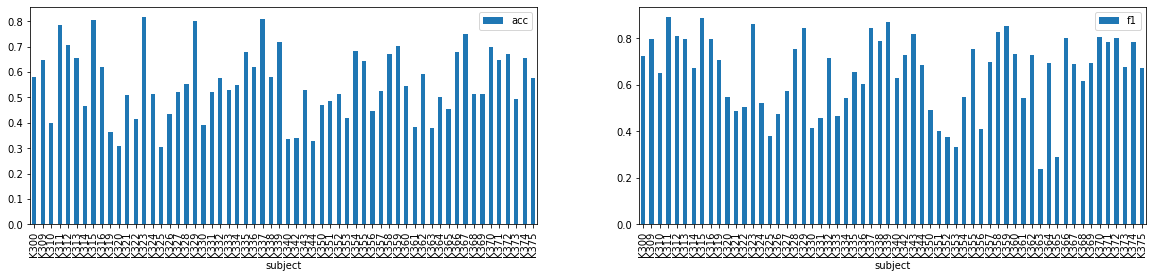

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [18]:
# intra-subject Cov-TangentSpace-LinearSVC
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.623936318706582
avg f1: 0.7149484570665078


<AxesSubplot:xlabel='subject'>

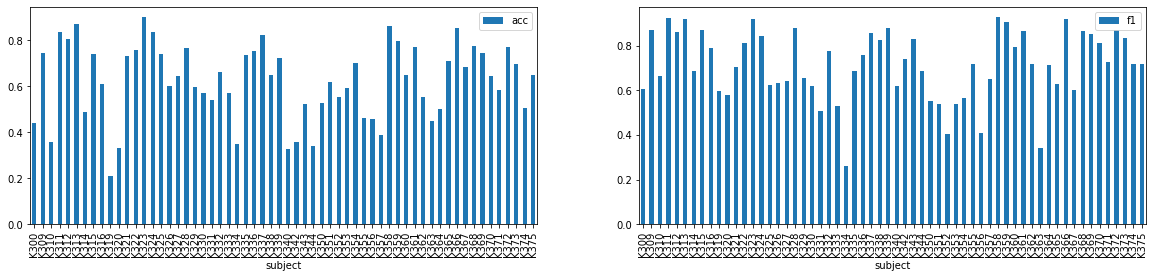

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [8]:
# LOSO - EA-CSP(8)-LinearSVM
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.3933075480180671
avg f1: 0.5736720148383614


<AxesSubplot:xlabel='subject'>

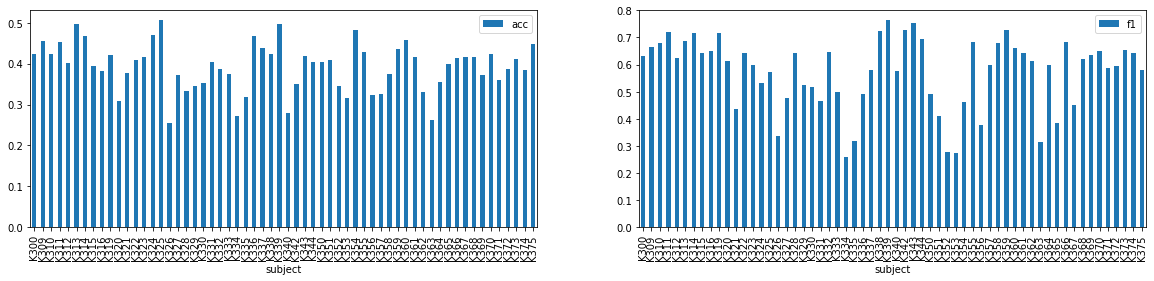

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [19]:
# LOSO - EA-CSP(4)-LinearSVM
result = pd.DataFrame({
    "subject": test_subjects,
    "acc": test_acc,
    "f1": test_f1,
})
print(f"avg acc: {result['acc'].mean()}")
print(f"avg f1: {result['f1'].mean()}")

avg acc: 0.3994425737885329
avg f1: 0.5779737755516616


<AxesSubplot:xlabel='subject'>

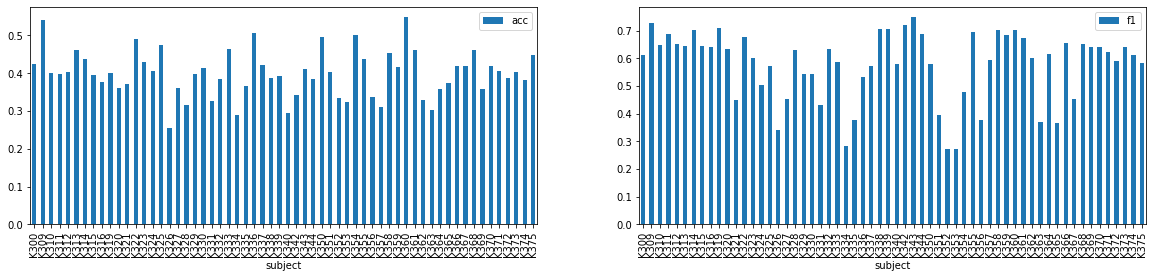

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
result.plot.bar(x="subject", y="acc", ax=axes[0])
result.plot.bar(x="subject", y="f1", ax=axes[1])

In [22]:
result.sort_values("acc", ascending=False).reset_index(drop=True)

,subject,acc,f1
0,K360,0.548153,0.703694
1,K309,0.539630,0.727471
2,K336,0.505985,0.534300
3,K354,0.500099,0.478048
4,K350,0.496006,0.579032
5,K322,0.490565,0.677919
6,K325,0.473747,0.571959
7,K333,0.463749,0.586101
8,K361,0.461376,0.674533
9,K368,0.460766,0.651432
